### Data visutalization

* Engordar la linea (5-10 pixeles)

##### Variaciones en el código:
* Las variables 'unitsx' y 'unitsy' que devolvia la función 'get_frame' las he tenido que borrar ya que no me reconocia 'match_units' (no se si es necesario ya que de momento solo uso x0 e y0).
* Para que la curva del ground truth concuerde con la imagen, solo hay que sumar y0, la coordenada x ya coincide de por si.

##### Dudas:
* Es necesario plotear la mascara binaria encima de la imagen??? (creo que no)
* Al aumentar el grosor de la máscara únicamente en columnas, este varia según el pendiente. He decidido hacerlo también a las filas para obtener una curva de grosor uniforme: el problema és que cuando hay una separación grande entre dos puntos aun aumentando el grosor sigen separados, no se si deberia unificar la curva o debe quedarse de esta forma.

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pydicom
import sak
import glob
import os.path

# codigo para extraer el bias inicial y que la curva y el GT coincidan

def get_region(dicom: pydicom.Dataset, ix_region: int):
    region  = dicom.get("SequenceOfUltrasoundRegions", [])[ix_region]
    x0      = region.RegionLocationMinX0
    x1      = region.RegionLocationMaxX1
    y0      = region.RegionLocationMinY0
    y1      = region.RegionLocationMaxY1
    xref    = region.ReferencePixelY0 if hasattr(region,"ReferencePixelX0")        else None
    yref    = region.ReferencePixelY0 if hasattr(region,"ReferencePixelY0")        else None
    deltax  = region.PhysicalDeltaX   if hasattr(region,"PhysicalDeltaX")          else None
    deltay  = region.PhysicalDeltaY   if hasattr(region,"PhysicalDeltaY")          else None

    return x0,x1,y0,y1,xref,yref,deltax,deltay

def get_frame(dicom: pydicom.Dataset, type: str = "doppler"):
    # Assert types
    if   type.lower() == "doppler":
        allowedSpatialFormats = [3]
        allowedDataTypes      = [3,4]
    elif type.lower() == "bmode":
        allowedSpatialFormats = [1]
        allowedDataTypes      = [1,2]
    elif type.lower() == "mmode":
        allowedSpatialFormats = [2]
        allowedDataTypes      = [1]
    else:
        raise ValueError(f"Frame type '{type}' not in ['doppler', 'bmode', 'mmode']")

    # Initialize values
    x0,x1,y0,y1,xref,yref,deltax,deltay,unitsx,unitsy = (None,None,None,None,None,None,None,None,None,None,)

    # Aggregate same doppler regions (DICOM format)
    first_match = False
    all_regions = dicom.get("SequenceOfUltrasoundRegions", [])
    for i,region in enumerate(all_regions):
        if ("RegionDataType" not in region):
            x0,x1,y0,y1,xref,yref,deltax,deltay,unitsx,unitsy = get_region(dicom,0)
        else:
            if (region.RegionDataType in allowedDataTypes) and (region.RegionSpatialFormat in allowedSpatialFormats):
                if first_match == False:
                    x0,x1,y0,y1,xref,yref,deltax,deltay = get_region(dicom,i)
                    first_match = True
                
                # Check if next region can be aggregated
                x0_new,x1_new,y0_new,y1_new,_,_,_,_ = get_region(dicom,i)
                if (y0 == y0_new) and (y1 == y1_new):
                    if x0_new <= x0:
                        x0 = x0_new
                    if x1_new >= x1:
                        x1 = x1_new
    
    return x0,x1,y0,y1,xref,yref,deltax,deltay

def get_modality(dicom: pydicom.Dataset):
    if "SequenceOfUltrasoundRegions" not in dicom:
        return None

    spatialformats,datatypes = [],[]
    for region in dicom.SequenceOfUltrasoundRegions:
        if ("RegionSpatialFormat" not in region) or ("RegionDataType" not in region):
            return None
        spatialformats.append(region.RegionSpatialFormat)
        datatypes.append(region.RegionDataType)
    spatialformats,datatypes = np.array(spatialformats),np.array(datatypes)

    # Determine type of image for analysis
    if   np.any(spatialformats == 2): # M-Mode
        modality = "M-Mode"
    elif np.any(spatialformats == 3):
        ix = np.where(spatialformats == 3)[0][0]
        if   datatypes[ix] == 3: # PW Spectral Doppler
            modality = "PW Doppler" # NEEDED DISTINGUISHING PW AND TDI (!!!)
        elif datatypes[ix] == 4: # CW Spectral Doppler
            modality = "CW Doppler"
        else: # Unknown
            modality = None
    elif np.all(spatialformats == 1) and (spatialformats.size == 1):
        modality = "2D"
    else:
        modality = None

    return modality

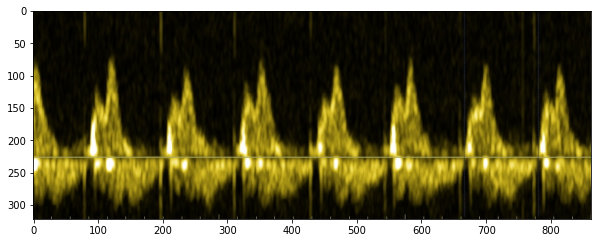

In [8]:
def convert_ybr_to_rgb(arr):
    if len(arr.shape) == 4:
        return np.vstack([convert_ybr_to_rgb(a)[np.newaxis] for a in arr])
    else:
        temp = arr[...,1].copy()
        arr[...,1] = arr[..., 2]
        arr[...,2] = temp
        return cv2.cvtColor(arr, cv2.COLOR_YCR_CB2RGB)

datadir = 'C:\\Users\\hp240\\Documents\\IAGO\\EBM\\TFG\\ALL_DOPPLER\\'

# loading of ground truth:
curves_x = sak.load_data(os.path.join(datadir,"x_coordinates.csv"))
curves_y = sak.load_data(os.path.join(datadir,"y_coordinates.csv"))
database = sak.load_data(os.path.join(datadir,"databases.csv"),dtype=str)

data = glob.glob(datadir+'*')

#for i in range(10):
#path = data[i]
#path = 'C:\\Users\hp240\Documents\IAGO\EBM\TFG\ALL_DOPPLER\\1.2.840.113619.2.435.385039104.1524568030.43.1' # el que sale bonito
path = 'C:\\Users\hp240\Documents\IAGO\EBM\TFG\ALL_DOPPLER\\1.2.840.113619.2.435.385039104.1534768661.94.1'
dicom = pydicom.dcmread(path)

x0,x1,y0,y1,xref,yref,deltax,deltay = get_frame(dicom,"doppler")
x = dicom.pixel_array.copy()[y0:y1, x0:x1,]
if dicom.get("PhotometricInterpretation", "RGB") in ['YBR_FULL', 'YBR_FULL_422']:
    x = convert_ybr_to_rgb(x)
gt_x = curves_x[dicom.SOPInstanceUID]
gt_y = curves_y[dicom.SOPInstanceUID]

plt.figure(1,figsize=(10,10))
plt.imshow(x)
#plt.plot(gt_x-x0,gt_y, 'r') # plot GT (solo hay que añadir bias en la coordenada y!)
plt.savefig('img_example2')

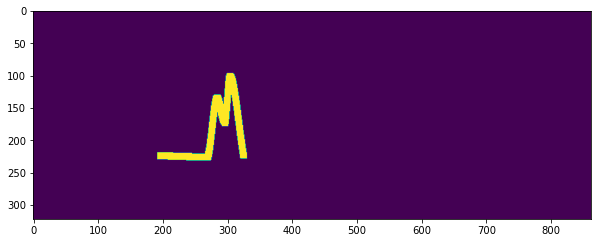

In [40]:
# TENGO QUE ARREGLAR ESTOOOOOOOOOOO !!!!!!!!!!!!

# GT como mascara binaria:
gt_mask = np.zeros(x.shape[:-1],dtype=bool)

gt_x_full = gt_x.copy() 
gt_y_full = gt_y.copy()

for i in range(gt_x.shape[0]-1):
    if gt_y[i+1]>gt_y[i]:
        s = 1
    else:
        s = -1
    for y in range(gt_y[i]+1,gt_y[i+1],s):
        gt_x_full = np.insert(gt_x_full,i+1,gt_x[i])
        gt_y_full = np.insert(gt_y_full,i+1,y)

line_width = 10
for i in range(-line_width//2,line_width//2):
    for j in range(-line_width//2,line_width//2):
        gt_mask[gt_y_full+i,gt_x_full-x0+j] = 1
            
plt.figure(figsize=(10,10))
plt.imshow(gt_mask) # NO SE PLOTEAN JUNTAS!!!!
#plt.imshow(x)

--------

In [4]:
#### provar lo de la regresion

import torch.nn as nn
import torch
import sak.torch.image.data.augmentation

x_torch = torch.tensor(x)[None,None]

inputs = {'x' : x_torch.float()}

sak.torch.image.data.augmentation.RescaleIntensity(inputs)

output = model(inputs)
out_numpy = output['sigmoid'].cpu().detach().numpy().squeeze()

NameError: name 'model' is not defined

In [ ]:
m = nn.Linear(gt_mask.shape, )
input = torch.randn(128, 1)
output = m(input)
print(output.size())

In [5]:
gt_mask.shape

(708, 1016)

In [16]:
#################### CODIGO PARA EXTRAER LA CURVA DE LA MASK ######################3

#plt.imshow(gt_mask)

vector = []
idxs = []

for i in range(gt_mask.shape[1]):
    col = gt_mask[:,i]
    tmp = False
    for idx, val in enumerate(col):
        if val != tmp:
            idxs.append(idx)
        tmp = val
    # miro si he encontrado o son todo 0:
    if len(idxs) == 0:
        idxs = [0,0]

    # salgo de la columna y calculo el valor:
    vector.append(sum(idxs)//2)

    idxs = []



######################## CREO QUE FUNCIONA BIEN ##########################
        

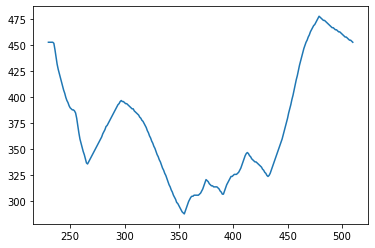

In [23]:
for ind, i in enumerate(vector):
    if i ==0:
        vector[ind] = None
plt.plot(vector)

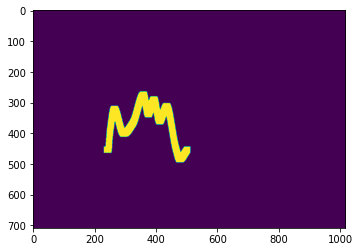

In [18]:
plt.imshow(gt_mask)

In [19]:
sum([,None])//2

TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

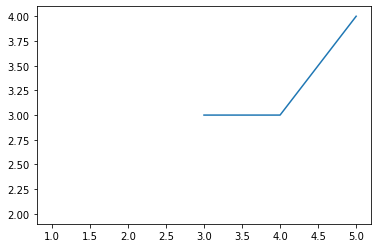

In [20]:
plt.plot([None, 2 , None, 3,3,4])